In [74]:
import sqlite3, matplotlib.pyplot as plt, pandas as pd, base64, io
%matplotlib inline
connection = sqlite3.connect('database.db')

def display_image(image_data):
    decoded_image = io.BytesIO(base64.b64decode(image_data))
    img = plt.imread(decoded_image, format='png')
    plt.figure(figsize=(9, 9))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Will techniques prevent overfitting?

In [75]:
df = pd.read_sql_query("""
    SELECT cf.*
    FROM configuration AS cf;
""", connection)
df

,id,transfer_learning,freeze_layers,balance_classes,segmentation,data_augmentation,normalization,custom_optimizer,callback
0,1,True,True,True,True,True,None,True,False
1,2,True,True,True,False,False,StandardScaler,False,False
2,3,False,False,False,False,True,None,False,False
3,4,False,False,False,False,False,None,False,False
4,5,False,False,True,False,False,None,False,False
5,6,False,False,False,True,False,None,False,False
6,7,True,True,False,False,False,None,False,False
7,8,True,True,False,False,True,None,False,False
8,9,True,True,True,False,True,None,False,False
9,10,True,True,True,False,True,MinMaxScaler,True,False


Overfitting can be referenced by:

* Large gap between validation and training curves

* Validation curve with noise and instability compared to training curve

Underfitting can be referenced by:

* Validation and training curves decreasing accuracy over the epochs

* Validation and training curves increasing loss over the epochs

The perfect match would be similar to a logarithmic curve

In [76]:
df = pd.read_sql_query("""
    SELECT nb.architecture, nb.loss_epochs, nb.accuracy_epochs, nb.auc_epochs, nb.recall_epochs, nb.precision_epochs, nb.configuration_id
    FROM notebook AS nb;
""", connection)

for index, row in df.iterrows():
    print(row['configuration_id'], row['architecture'])
    #display_image(row['accuracy_epochs'])
    #display_image(row['loss_epochs'])
    #display_image(row['auc_epochs'])
    #display_image(row['recall_epochs'])
    #display_image(row['precision_epochs'])

1 ConvNeXt
1 ResNetV2
1 Xception
2 ConvNeXt
2 ResNetV2
2 Xception
3 ConvNeXt
3 ResNetV2
3 Xception
4 ConvNeXt
4 ResNetV2
4 Xception
5 ConvNeXt
5 ResNetV2
5 Xception
6 ConvNeXt
6 ResNetV2
6 Xception
7 ConvNeXt
7 ResNetV2
7 Xception
8 ConvNeXt
8 ResNetV2
8 Xception
9 ConvNeXt
9 ResNetV2
9 Xception
10 ConvNeXt
10 ResNetV2
11 ConvNeXt
11 ResNetV2
11 Xception
12 ConvNeXt
12 ResNetV2
12 Xception
13 ConvNeXt
13 ResNetV2
13 Xception
14 ConvNeXt
14 ResNetV2
14 Xception


Graphs have different scales - TODO - adjust to better visualization

## A model with more layers will have better results compared to others?

### Better results considering metrics from each model training
In terms of metrics, the query below shows how many classes of each model (configurationId) have all metrics value higher than 50%

In [77]:
df = pd.read_sql_query("""
    SELECT nb.architecture || ' (' || nb.configuration_id ||')' as name, count(*) as total
    FROM metrics AS met JOIN notebook AS nb
    ON met.notebook_id = nb.id
    WHERE met.precision > .5 AND met.f1_score > .5 AND met.roc_auc > .5 AND met.specificity > .5 AND met.recall > .5 AND nb.accuracy > .5
    GROUP BY nb.name
    ORDER BY count(*) DESC;
""", connection)
df

,name,total
0,ConvNeXt (8),7
1,ConvNeXt (7),4
2,ConvNeXt (9),4
3,ConvNeXt (12),2
4,ConvNeXt (2),2
5,Xception (12),1
6,Xception (7),1
7,Xception (9),1
8,Xception (8),1
9,Xception (2),1


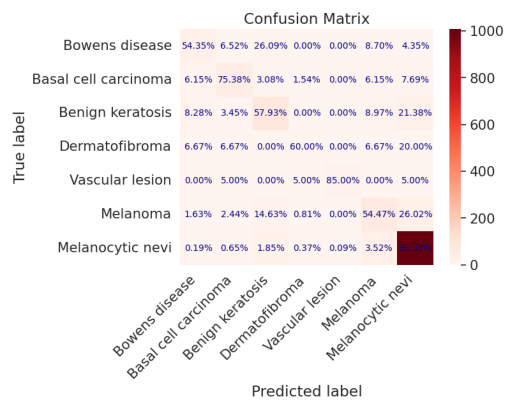

0    None
Name: confusion_matrix, dtype: object

In [78]:
df = pd.read_sql_query("""
    SELECT nb.confusion_matrix
    FROM metrics AS met JOIN notebook AS nb
    ON met.notebook_id = nb.id
    WHERE met.precision > .5 and met.f1_score > .5 and met.roc_auc > .5 and met.specificity > .5 and met.recall > .5 and nb.accuracy > .5
    group by nb.name
    ORDER BY count(*) DESC
    LIMIT 1;
""", connection)
df['confusion_matrix'].apply(display_image)

Indeed ConvNeXt has more classes with all metrics above 50%

### Mean metric values from notebooks
Average metrics from each architecture

In [79]:
df = pd.read_sql_query("""
    SELECT nb.architecture, AVG(nb.loss) AS average_loss, AVG(nb.accuracy) AS average_accuracy, AVG(nb.auc) AS average_auc, AVG(nb.recall) AS average_recall, AVG(nb.precision) AS average_precision
    FROM notebook AS nb
    GROUP BY nb.architecture;
""", connection)
df

,architecture,average_loss,average_accuracy,average_auc,average_recall,average_precision
0,ConvNeXt,5.223859,0.279758,0.918423,0.690906,0.777911
1,ResNetV2,271.312468,0.408676,0.846801,0.632530,0.697157
2,Xception,237.851805,0.398135,0.818764,0.589383,0.643607


ConvNeXt has the best results, except for average accuracy which Xception performed better, however considering the other metrics, Xception would be the third

### Mean metric values from classes

In [80]:
df = pd.read_sql_query("""
    SELECT met.type, AVG(met.precision) AS average_precision, AVG(met.f1_score) AS average_f1_score, AVG(met.roc_auc) AS average_ROC_AUC, AVG(met.recall) AS average_recall, AVG(met.specificity) AS average_specificity
    FROM metrics AS met
    GROUP BY met.type;
""", connection)
df

,type,average_precision,average_f1_score,average_ROC_AUC,average_recall,average_specificity
0,Basal_cell_carcinoma,0.365867,0.333683,0.842942,0.385741,0.956630
1,Benign_keratosis,0.387104,0.347600,0.791087,0.387384,0.920429
2,Bowens_disease,0.282644,0.242518,0.817128,0.269883,0.976132
3,Dermatofibroma,0.229438,0.188702,0.796579,0.250407,0.982157
4,Melanocytic_nevi,0.892579,0.829991,0.841540,0.799955,0.721044
5,Melanoma,0.354158,0.304223,0.779940,0.326591,0.935369
6,Vascular_lesion,0.395517,0.348344,0.826230,0.439024,0.966542


In [81]:
df = pd.read_sql_query("""
    SELECT nb.architecture, met.type, AVG(met.precision) AS average_precision, AVG(met.f1_score) AS average_f1_score, AVG(met.roc_auc) AS average_ROC_AUC, AVG(met.recall) AS average_recall, AVG(met.specificity) AS average_specificity
    FROM metrics AS met JOIN notebook AS nb
    ON met.notebook_id = nb.id
    GROUP BY met.type,nb.architecture;
""", connection)
df

,architecture,type,average_precision,average_f1_score,average_ROC_AUC,average_recall,average_specificity
0,ConvNeXt,Basal_cell_carcinoma,0.516999,0.506272,0.915625,0.539560,0.971309
1,ResNetV2,Basal_cell_carcinoma,0.267418,0.269916,0.822097,0.387912,0.925122
2,Xception,Basal_cell_carcinoma,0.309131,0.216491,0.787116,0.217752,0.974754
3,ConvNeXt,Benign_keratosis,0.456115,0.427612,0.843446,0.430049,0.948692
4,ResNetV2,Benign_keratosis,0.392104,0.324114,0.760801,0.361576,0.916128
5,Xception,Benign_keratosis,0.307400,0.286725,0.767317,0.369231,0.894623
6,ConvNeXt,Bowens_disease,0.414216,0.350459,0.892294,0.375776,0.975286
7,ResNetV2,Bowens_disease,0.227326,0.180265,0.766842,0.173913,0.984955
8,Xception,Bowens_disease,0.200525,0.193316,0.790335,0.259197,0.967542
9,ConvNeXt,Dermatofibroma,0.454209,0.332788,0.868914,0.314286,0.995026


ConvNeXt = C, ResNetV2 = R, Xception = X

Type | Precision | F1 Score | ROC AUC | Recall | Specificity
:---: | :---: | :---: | :---: | :---: | :---:
Basal_cell_carcinoma | C | C | C | C | X
Benign_keratosis | C | C | C | C | C
Bowens_disease | C | C | C | C | R
Dermatofibroma | C | C | C | C | C
Melanocytic_nevi | X | C | C | C | X
**Melanoma** | C | C | C | X | R
Vascular_lesion | C | C | C | C | C

In [82]:
df = pd.read_sql_query("""
    SELECT nb.architecture, AVG(met.precision) AS average_precision, AVG(met.f1_score) AS average_f1_score, AVG(met.roc_auc) AS average_ROC_AUC, AVG(met.recall) AS average_recall, AVG(met.specificity) AS average_specificity
    FROM metrics AS met JOIN notebook AS nb
    ON met.notebook_id = nb.id
    GROUP BY nb.architecture;
""", connection)
df

,architecture,average_precision,average_f1_score,average_ROC_AUC,average_recall,average_specificity
0,ConvNeXt,0.545185,0.494717,0.880260,0.504421,0.932611
1,ResNetV2,0.361326,0.313254,0.780909,0.355494,0.920205
2,Xception,0.333644,0.299081,0.777130,0.362053,0.914444


After analysis, the inference is the ConvNeXt architecture have best overall metrics values, in other words, an architecture with more layers performed better than others

## What would be the impact of each technique?

In [83]:
df = pd.read_sql_query("""
    SELECT cf.id AS conf_id, cf.data_augmentation, cf.transfer_learning, cf.segmentation, cf.balance_classes, AVG(nb.loss) AS average_loss, AVG(nb.accuracy) AS average_accuracy, AVG(nb.auc) AS average_auc, AVG(nb.recall) AS average_recall, AVG(nb.precision) AS average_precision
    FROM notebook AS nb JOIN configuration AS cf ON cf.id = nb.configuration_id
    GROUP BY cf.id;
""", connection)
df

,conf_id,data_augmentation,transfer_learning,segmentation,balance_classes,average_loss,average_accuracy,average_auc,average_recall,average_precision
0,1,True,True,True,True,4.434999,0.123478,0.875329,0.707497,0.719702
1,2,False,True,False,True,28.467390,0.744502,0.847069,0.723338,0.723338
2,3,True,False,False,False,1.025738,0.003665,0.946757,0.703034,0.755215
3,4,False,False,False,False,0.836105,0.000414,0.944088,0.626506,0.834031
4,5,False,False,False,True,4.032384,0.061452,0.806936,0.347613,0.602892
5,6,False,False,True,False,0.748712,0.002040,0.953680,0.688309,0.823954
6,7,False,True,False,False,723.806834,0.842800,0.771175,0.601963,0.602144
7,8,True,True,False,False,394.568133,0.910722,0.862120,0.762383,0.762383
8,9,True,True,False,True,384.992309,0.917575,0.862257,0.761490,0.761490
9,10,True,True,False,True,1.180195,0.000000,0.886532,0.391232,0.692097


Metric | Best | Worst
:---: | :---: | :---:
Loss | 6 | 7
Accuracy | 9 | 4
AUC | 6 | 7
Recall | 8 | 5
Precision | 4 | 7

Apparent best configurationId = 6

Apparent worst configurationId = 7

### Data augmentation
configurationIds = 3 & 4 | 7 & 8 | 1 & 14 | 9 & 12 | 11 & 13

#### Configurations 3 & 4

In [84]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (3,4)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Basal_cell_carcinoma,0.571429,0.491228,0.933348,0.430769,0.985304
1,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Basal_cell_carcinoma,0.448276,0.276596,0.939893,0.200000,0.988803
2,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Benign_keratosis,0.409722,0.408304,0.859252,0.406897,0.936990
3,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Benign_keratosis,0.325000,0.231111,0.774316,0.179310,0.959970
4,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Bowens_disease,0.283333,0.320755,0.902129,0.369565,0.970304
5,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Bowens_disease,0.192308,0.138889,0.876231,0.108696,0.985497
6,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Dermatofibroma,0.375000,0.387097,0.941131,0.400000,0.993239
7,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Dermatofibroma,0.000000,0.000000,0.920622,0.000000,1.000000
8,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Melanocytic_nevi,0.899119,0.873870,0.898045,0.850000,0.751208
9,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Melanocytic_nevi,0.785607,0.868268,0.871075,0.970370,0.309179


#### Configurations 7 & 8

In [85]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (7,8)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Basal_cell_carcinoma,0.567164,0.575758,0.922178,0.584615,0.979706
1,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Basal_cell_carcinoma,0.710145,0.731343,0.926328,0.753846,0.986004
2,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Benign_keratosis,0.508982,0.544872,0.887866,0.586207,0.939214
3,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Benign_keratosis,0.617647,0.597865,0.867682,0.579310,0.961453
4,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Bowens_disease,0.608696,0.405797,0.864851,0.304348,0.993785
5,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Bowens_disease,0.543478,0.543478,0.882266,0.543478,0.985497
6,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Dermatofibroma,1.000000,0.235294,0.697543,0.133333,1.000000
7,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Dermatofibroma,0.562500,0.580645,0.895831,0.600000,0.995267
8,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Melanocytic_nevi,0.898320,0.919041,0.883058,0.940741,0.722222
9,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Melanocytic_nevi,0.931608,0.932470,0.894331,0.933333,0.821256


#### Configurations 1 & 14

In [86]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (1,14)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Basal_cell_carcinoma,0.761905,0.750000,0.987242,0.738462,0.989503
1,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Basal_cell_carcinoma,0.520000,0.557143,0.969489,0.600000,0.974808
2,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Benign_keratosis,0.591549,0.585366,0.921198,0.579310,0.957005
3,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Benign_keratosis,0.538922,0.576923,0.927757,0.620690,0.942921
4,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Bowens_disease,0.480000,0.338028,0.962992,0.260870,0.991022
5,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Bowens_disease,0.456140,0.504854,0.958924,0.565217,0.978591
6,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Dermatofibroma,0.875000,0.608696,0.976020,0.466667,0.999324
7,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Dermatofibroma,0.333333,0.363636,0.943881,0.400000,0.991886
8,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Melanocytic_nevi,0.919164,0.928015,0.957582,0.937037,0.785024
9,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Melanocytic_nevi,0.951346,0.898338,0.943968,0.850926,0.886473


#### Configurations 9 & 12

In [87]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (9,12)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,9,ConvNeXt,21.231993,0.909352,0.815261,0.815261,0.896011,Basal_cell_carcinoma,0.578313,0.648649,0.914502,0.738462,0.975507
1,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Basal_cell_carcinoma,0.645833,0.548673,0.925672,0.476923,0.988104
2,9,ConvNeXt,21.231993,0.909352,0.815261,0.815261,0.896011,Benign_keratosis,0.539394,0.574194,0.862059,0.613793,0.943662
3,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Benign_keratosis,0.379679,0.427711,0.857746,0.489655,0.914010
4,9,ConvNeXt,21.231993,0.909352,0.815261,0.815261,0.896011,Bowens_disease,0.571429,0.266667,0.762964,0.173913,0.995856
5,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Bowens_disease,0.333333,0.455172,0.961341,0.717391,0.954420
6,9,ConvNeXt,21.231993,0.909352,0.815261,0.815261,0.896011,Dermatofibroma,0.600000,0.480000,0.829908,0.400000,0.997295
7,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Dermatofibroma,0.285714,0.400000,0.947307,0.666667,0.983097
8,9,ConvNeXt,21.231993,0.909352,0.815261,0.815261,0.896011,Melanocytic_nevi,0.877430,0.917366,0.829887,0.961111,0.649758
9,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Melanocytic_nevi,0.948335,0.846745,0.903270,0.764815,0.891304


#### Configurations 11 & 13

In [88]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (11,13)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Basal_cell_carcinoma,0.820000,0.713043,0.981709,0.630769,0.993702
1,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Basal_cell_carcinoma,0.517241,0.592105,0.965409,0.692308,0.970609
2,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Benign_keratosis,0.659091,0.628159,0.934414,0.600000,0.966642
3,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Benign_keratosis,0.550633,0.574257,0.927118,0.600000,0.947368
4,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Bowens_disease,0.636364,0.622222,0.971115,0.608696,0.988950
5,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Bowens_disease,0.380000,0.395833,0.939046,0.413043,0.978591
6,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Dermatofibroma,0.800000,0.400000,0.967455,0.266667,0.999324
7,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Dermatofibroma,0.375000,0.387097,0.950958,0.400000,0.993239
8,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Melanocytic_nevi,0.897436,0.918137,0.941783,0.939815,0.719807
9,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Melanocytic_nevi,0.954728,0.915140,0.958510,0.878704,0.891304


### Segmentation
configurationIds = 1 & 11 | 4 & 6 | 14 & 13

#### Configurations 1 & 11

In [89]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (1,11)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Basal_cell_carcinoma,0.761905,0.750000,0.987242,0.738462,0.989503
1,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Basal_cell_carcinoma,0.820000,0.713043,0.981709,0.630769,0.993702
2,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Benign_keratosis,0.591549,0.585366,0.921198,0.579310,0.957005
3,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Benign_keratosis,0.659091,0.628159,0.934414,0.600000,0.966642
4,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Bowens_disease,0.480000,0.338028,0.962992,0.260870,0.991022
5,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Bowens_disease,0.636364,0.622222,0.971115,0.608696,0.988950
6,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Dermatofibroma,0.875000,0.608696,0.976020,0.466667,0.999324
7,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Dermatofibroma,0.800000,0.400000,0.967455,0.266667,0.999324
8,1,ConvNeXt,0.473472,0.000000,0.851671,0.818608,0.981422,Melanocytic_nevi,0.919164,0.928015,0.957582,0.937037,0.785024
9,11,ConvNeXt,0.495621,0.000000,0.855742,0.817938,0.978213,Melanocytic_nevi,0.897436,0.918137,0.941783,0.939815,0.719807


#### Configurations 4 & 6

In [90]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (4,6)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Basal_cell_carcinoma,0.448276,0.276596,0.939893,0.200000,0.988803
1,6,ConvNeXt,0.782848,0.000000,0.798129,0.685408,0.950416,Basal_cell_carcinoma,0.376471,0.426667,0.924907,0.492308,0.962911
2,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Benign_keratosis,0.325000,0.231111,0.774316,0.179310,0.959970
3,6,ConvNeXt,0.782848,0.000000,0.798129,0.685408,0.950416,Benign_keratosis,0.300000,0.294737,0.775174,0.289655,0.927354
4,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Bowens_disease,0.192308,0.138889,0.876231,0.108696,0.985497
5,6,ConvNeXt,0.782848,0.000000,0.798129,0.685408,0.950416,Bowens_disease,0.666667,0.218182,0.872012,0.130435,0.997928
6,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Dermatofibroma,0.000000,0.000000,0.920622,0.000000,1.000000
7,6,ConvNeXt,0.782848,0.000000,0.798129,0.685408,0.950416,Dermatofibroma,0.200000,0.160000,0.947577,0.133333,0.994591
8,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Melanocytic_nevi,0.785607,0.868268,0.871075,0.970370,0.309179
9,6,ConvNeXt,0.782848,0.000000,0.798129,0.685408,0.950416,Melanocytic_nevi,0.837426,0.874834,0.879574,0.915741,0.536232


#### Configurations 13 & 14

In [91]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (13,14)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Basal_cell_carcinoma,0.517241,0.592105,0.965409,0.692308,0.970609
1,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Basal_cell_carcinoma,0.520000,0.557143,0.969489,0.600000,0.974808
2,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Benign_keratosis,0.550633,0.574257,0.927118,0.600000,0.947368
3,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Benign_keratosis,0.538922,0.576923,0.927757,0.620690,0.942921
4,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Bowens_disease,0.380000,0.395833,0.939046,0.413043,0.978591
5,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Bowens_disease,0.456140,0.504854,0.958924,0.565217,0.978591
6,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Dermatofibroma,0.375000,0.387097,0.950958,0.400000,0.993239
7,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Dermatofibroma,0.333333,0.363636,0.943881,0.400000,0.991886
8,13,ConvNeXt,0.562903,0.000000,0.839787,0.740295,0.973310,Melanocytic_nevi,0.954728,0.915140,0.958510,0.878704,0.891304
9,14,ConvNeXt,0.614947,0.000000,0.832959,0.744311,0.967933,Melanocytic_nevi,0.951346,0.898338,0.943968,0.850926,0.886473


### Transfer Learning
configurationIds = 3 & 8 | 4 & 7 | 5 & 12

#### Configurations 3 & 8

In [92]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (3,8)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Basal_cell_carcinoma,0.571429,0.491228,0.933348,0.430769,0.985304
1,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Basal_cell_carcinoma,0.710145,0.731343,0.926328,0.753846,0.986004
2,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Benign_keratosis,0.409722,0.408304,0.859252,0.406897,0.936990
3,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Benign_keratosis,0.617647,0.597865,0.867682,0.579310,0.961453
4,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Bowens_disease,0.283333,0.320755,0.902129,0.369565,0.970304
5,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Bowens_disease,0.543478,0.543478,0.882266,0.543478,0.985497
6,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Dermatofibroma,0.375000,0.387097,0.941131,0.400000,0.993239
7,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Dermatofibroma,0.562500,0.580645,0.895831,0.600000,0.995267
8,3,ConvNeXt,0.991117,0.000765,0.747552,0.715529,0.944856,Melanocytic_nevi,0.899119,0.873870,0.898045,0.850000,0.751208
9,8,ConvNeXt,13.903800,0.895391,0.842704,0.842704,0.910296,Melanocytic_nevi,0.931608,0.932470,0.894331,0.933333,0.821256


#### Configurations 4 & 7

In [93]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (4,7)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Basal_cell_carcinoma,0.448276,0.276596,0.939893,0.200000,0.988803
1,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Basal_cell_carcinoma,0.567164,0.575758,0.922178,0.584615,0.979706
2,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Benign_keratosis,0.325000,0.231111,0.774316,0.179310,0.959970
3,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Benign_keratosis,0.508982,0.544872,0.887866,0.586207,0.939214
4,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Bowens_disease,0.192308,0.138889,0.876231,0.108696,0.985497
5,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Bowens_disease,0.608696,0.405797,0.864851,0.304348,0.993785
6,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Dermatofibroma,0.000000,0.000000,0.920622,0.000000,1.000000
7,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Dermatofibroma,1.000000,0.235294,0.697543,0.133333,1.000000
8,4,ConvNeXt,0.801396,0.000000,0.788348,0.715529,0.950548,Melanocytic_nevi,0.785607,0.868268,0.871075,0.970370,0.309179
9,7,ConvNeXt,9.860565,0.823580,0.809109,0.808568,0.898529,Melanocytic_nevi,0.898320,0.919041,0.883058,0.940741,0.722222


#### Configurations 5 & 12

In [94]:
df = pd.read_sql_query("""
    SELECT nb.configuration_id, nb.architecture, nb.loss , nb.accuracy, nb."precision", nb.recall, nb.auc, met."type", met."precision", met.f1_score, met.roc_auc, met.recall, met.specificity
    FROM notebook AS nb
    JOIN metrics AS met
    ON nb.id = met.notebook_id
    WHERE nb.configuration_id in (5,12)
    ORDER BY nb.architecture, met."type";
""", connection)
df

,configuration_id,architecture,loss,accuracy,precision,recall,auc,type,precision,f1_score,roc_auc,recall,specificity
0,5,ConvNeXt,1.304403,0.000000,0.637081,0.432396,0.864721,Basal_cell_carcinoma,0.164794,0.265060,0.841298,0.676923,0.843947
1,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Basal_cell_carcinoma,0.645833,0.548673,0.925672,0.476923,0.988104
2,5,ConvNeXt,1.304403,0.000000,0.637081,0.432396,0.864721,Benign_keratosis,0.252874,0.275862,0.699098,0.303448,0.903632
3,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Benign_keratosis,0.379679,0.427711,0.857746,0.489655,0.914010
4,5,ConvNeXt,1.304403,0.000000,0.637081,0.432396,0.864721,Bowens_disease,0.285714,0.179104,0.839299,0.130435,0.989641
5,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Bowens_disease,0.333333,0.455172,0.961341,0.717391,0.954420
6,5,ConvNeXt,1.304403,0.000000,0.637081,0.432396,0.864721,Dermatofibroma,0.095238,0.111111,0.810638,0.133333,0.987153
7,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Dermatofibroma,0.285714,0.400000,0.947307,0.666667,0.983097
8,5,ConvNeXt,1.304403,0.000000,0.637081,0.432396,0.864721,Melanocytic_nevi,0.910811,0.740659,0.818311,0.624074,0.840580
9,12,ConvNeXt,12.785114,0.716963,0.705291,0.704819,0.845576,Melanocytic_nevi,0.948335,0.846745,0.903270,0.764815,0.891304


## Will data augmentation result in a balance between metrics even though reduce its values?

In [95]:
df = pd.read_sql_query("""
    SELECT cf.id AS conf_id, cf.data_augmentation, cf.transfer_learning, cf.balance_classes, cf.segmentation, AVG(nb.loss) AS average_loss, AVG(nb.accuracy) AS average_accuracy, AVG(nb.auc) AS average_auc, AVG(nb.recall) AS average_recall, AVG(nb.precision) AS average_precision
    FROM notebook AS nb JOIN configuration AS cf
    ON nb.configuration_id = cf.id
    GROUP BY cf.id
    ORDER BY cf.data_augmentation DESC, cf.transfer_learning DESC, cf.balance_classes DESC, cf.segmentation DESC;
""", connection)
df

,conf_id,data_augmentation,transfer_learning,balance_classes,segmentation,average_loss,average_accuracy,average_auc,average_recall,average_precision
0,1,True,True,True,True,4.434999,0.123478,0.875329,0.707497,0.719702
1,9,True,True,True,False,384.992309,0.917575,0.862257,0.761490,0.761490
2,10,True,True,True,False,1.180195,0.000000,0.886532,0.391232,0.692097
3,11,True,True,True,False,5.493853,0.093804,0.847888,0.647479,0.661518
4,8,True,True,False,False,394.568133,0.910722,0.862120,0.762383,0.762383
5,3,True,False,False,False,1.025738,0.003665,0.946757,0.703034,0.755215
6,14,False,True,True,True,6.307056,0.215975,0.856686,0.654172,0.684921
7,2,False,True,True,False,28.467390,0.744502,0.847069,0.723338,0.723338
8,12,False,True,True,False,756.753404,0.828361,0.797249,0.641678,0.641835
9,13,False,True,True,False,8.940302,0.193154,0.823434,0.603748,0.637793


In [96]:
df = pd.read_sql_query("""
    SELECT cf.id AS conf_id, cf.data_augmentation, cf.transfer_learning, cf.balance_classes, cf.segmentation, AVG(met.precision) AS average_precision, AVG(met.f1_score) AS average_f1_score, AVG(met.roc_auc) AS average_ROC_AUC, AVG(met.recall) AS average_recall, AVG(met.specificity) AS average_specificity
    FROM metrics AS met JOIN notebook AS nb
    ON met.notebook_id = nb.id
    JOIN configuration AS cf
    ON nb.configuration_id = cf.id
    GROUP BY cf.id
    ORDER BY cf.data_augmentation DESC, cf.transfer_learning DESC, cf.balance_classes DESC, cf.segmentation DESC;
""", connection)
df

,conf_id,data_augmentation,transfer_learning,balance_classes,segmentation,average_precision,average_f1_score,average_ROC_AUC,average_recall,average_specificity
0,1,True,True,True,True,0.505975,0.444543,0.896705,0.486738,0.930380
1,9,True,True,True,False,0.551536,0.429659,0.709976,0.423450,0.926735
2,10,True,True,True,False,0.330919,0.331020,0.789939,0.363790,0.912940
3,11,True,True,True,False,0.446332,0.406135,0.892822,0.469064,0.929117
4,8,True,True,False,False,0.512209,0.451127,0.720321,0.452022,0.930471
5,3,True,False,False,False,0.459005,0.445297,0.900915,0.465385,0.928422
6,14,False,True,True,True,0.379186,0.390607,0.866443,0.464568,0.935232
7,2,False,True,True,False,0.481668,0.429987,0.797469,0.434394,0.926536
8,12,False,True,True,False,0.370318,0.383413,0.747312,0.475064,0.933787
9,13,False,True,True,False,0.375381,0.370552,0.859959,0.457418,0.932084


### Closing database connection

In [97]:
connection.close()